In [1]:
import tensorflow as tf
import os
import numpy as np
from mit_eye import mit_itraker
import time
sess=tf.InteractiveSession()

In [ ]:
with tf.name_scope('PlaceHolder'):
    LeftEye=tf.placeholder(tf.float32,[None,64,64,3],name='LeftEye')
    RightEye=tf.placeholder(tf.float32,[None,64,64,3],'RightEye')
    FaceOri=tf.placeholder(tf.float32,[None,64,64,3],'FaceOri')
    FaceMask=tf.placeholder(tf.float32,[None,25,25],'FaceMask')
    Y=tf.placeholder(tf.float32,[None,2],name='Y')
    LR=tf.placeholder(tf.float32,name='Learning_rate')
    REG_RATE=tf.placeholder(tf.float32,name='Reg_rate')
    DROPOUT=tf.placeholder(tf.float32,name='DropOut_rate')
    BN_FLAG=tf.placeholder(tf.bool,name='BatchNormalizeFlag')

In [ ]:
with tf.name_scope('MIT_Model'):
    model=mit_itraker(r'D:\Data warehouse\Face_Picture\eye_tracker_train_and_val',LeftEye,RightEye,FaceOri,FaceMask,\
                      dropout=DROPOUT,bn_train=BN_FLAG,reg_rate=REG_RATE)
    y_pre=model.coordinate

In [ ]:
with tf.name_scope('LOSS'):
    Loss=(tf.losses.mean_squared_error(Y,y_pre))+tf.add_n(tf.get_collection('loss_w'))
    tf.summary.scalar('loss',Loss)
    ERR=tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.squared_difference(y_pre, Y), axis=1)))
    tf.summary.scalar('err',ERR)
with tf.name_scope('Trainer'):
    Trainer=tf.train.AdamOptimizer(LR).minimize(Loss)

with tf.name_scope('Logger'):
    init=tf.global_variables_initializer()

    writer_tr=tf.summary.FileWriter('./mylog/test',sess.graph)
    writer_te=tf.summary.FileWriter('./mylog/val')
    merge=tf.summary.merge_all()

In [ ]:
data=model.data
bn_ops=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
'''
['val_face', 'train_eye_left', 'train_y', 'train_eye_right', 'val_y', 'train_face_mask', 'train_face',
'val_eye_right', 'val_face_mask', 'val_eye_left']
'''

In [ ]:
#重新训练
sess.run(init)
saver=tf.train.Saver()

In [ ]:
#加载保存的模型，继续训练
saver=tf.train.Saver()
#saver=tf.train.Saver()
saver.restore(sess,'./model_save/model_mit/model_err106.ckpt-44270')

In [ ]:
#130 个loop用时1分钟 无BN,dropout
#5000 个loop用时1h 有BN,dropout
batch_size=128
dp_=0.5
lr_=1e-3
rg_rate_=9e-5
s_time=time.time()
best_val_err=100
err_delta=0.1
for i_ in range(100*60*9,5000*2+100*60*9):
    mask=np.random.choice(range(48000),batch_size,replace=False)
    face_,face_mask_=data['train_face'][mask],data['train_face_mask'][mask]
    left_eye_,right_eye_=data['train_eye_left'][mask],data['train_eye_right'][mask]
    y_=data['train_y'][mask]
    feed_dict={LeftEye:left_eye_,  RightEye:right_eye_,  FaceOri:face_,  FaceMask:face_mask_,\
              Y:y_,LR:lr_,  DROPOUT:dp_,  BN_FLAG:True,  REG_RATE:rg_rate_}
    sess.run([Trainer,bn_ops],feed_dict=feed_dict)
    if i_%5==0:
        feed_dict={LeftEye:left_eye_,RightEye:right_eye_,FaceOri:face_,FaceMask:face_mask_,\
              Y:y_,LR:lr_,DROPOUT:1.,BN_FLAG:False,REG_RATE:rg_rate_}
        loss_,m_,_=sess.run([Loss,merge,bn_ops],feed_dict=feed_dict)
        writer_tr.add_summary(m_,i_)
        #print('epoch:{},loss:{}'.format(i_,loss_))
    if i_%10==0:
        mask=np.random.choice(range(5000),batch_size,replace=False)
        face_,face_mask_=data['val_face'][mask],data['val_face_mask'][mask]
        left_eye_,right_eye_=data['val_eye_left'][mask],data['val_eye_right'][mask]
        y_=data['val_y'][mask]
        feed_dict={LeftEye:left_eye_,RightEye:right_eye_,FaceOri:face_,FaceMask:face_mask_,\
                  Y:y_,LR:lr_,DROPOUT:1.,BN_FLAG:False,REG_RATE:rg_rate_}
        loss_,err_,m_,_=sess.run([Loss,ERR,merge,bn_ops],feed_dict=feed_dict)
        writer_te.add_summary(m_,i_)
        print('--epoch:{},loss:{},error:{}'.format(i_,loss_,err_))
        #保存模型
        if err_<1.9:
            if err_+err_delta<best_val_err:
                best_val_err=err_
                err_val=str(int(err_*100))
                saver.save(sess,'./model_save/model_mit/model_err'+err_val+'.ckpt',global_step=i_)
                print('epoch:{},best err:{},model save'.format(i_,best_val_err))
    if i_%(100*60)==0:
        lr_*=0.9
        print("**epoch:{},lr:{}".format(i_,lr_))
e_time=time.time()
run_time=e_time-s_time
print('Trainning Time:{:.0f} h,{:.0f} min,{:.2f} sec'.format(run_time//3600,(run_time%3600)//60,run_time%60))


In [ ]:
#i_ 53999

In [ ]:
#run_time=time.time()-s_time
print('Trainning Time:{:.0f} h,{:.0f} min,{:.2f} sec'.format(run_time//3600,(run_time%3600)//60,run_time%60))

In [ ]:
#保存模型
saver=tf.train.Saver()
saver.save(sess,'./model_save/model_err17.ckpt',global_step=130*60*3)

In [ ]:
#加载模型
saver=tf.train.Saver()
saver.restore(sess,'./model_save/model_mit/model_err106.ckpt-44270')

In [ ]:
batch_size=128
mask=np.random.choice(range(5000),batch_size,replace=False)
face_,face_mask_=data['val_face'][mask],data['val_face_mask'][mask]
left_eye_,right_eye_=data['val_eye_left'][mask],data['val_eye_right'][mask]
y_=data['val_y'][mask]
feed_dict={LeftEye:left_eye_,RightEye:right_eye_,FaceOri:face_,FaceMask:face_mask_,\
          Y:y_,LR:1e-3}
loss_,m_=sess.run([Loss,merge],feed_dict=feed_dict)

In [3]:
data={}
mean_val=[]
file_addr=r'D:\Data warehouse\Face_Picture\eye_tracker_train_and_val'
for i in [ 'val_y.npy',
          'val_eye_left.npy',
          'val_eye_right.npy',
          'val_face.npy',
          'val_face_mask.npy',
          'train_y.npy']:
    d_=np.load(os.path.join(file_addr,i))
    ori_shape=d_.shape
    d_=d_.reshape(ori_shape[0],-1).astype('float32')
    if i[-5] !='y':
        #使得所有值小于 1
        d_/=255.0
        #使得均值为0
        mean_=np.mean(d_,axis=0)
        d_-=mean_
        mean_val.append(mean_)
    data[i[:-4]]=d_.reshape(ori_shape)
print('Load Data Done~')

Load Data Done~


In [ ]:
data['train_y'].shape

In [ ]:
np.min(data['val_y'][:,0]),np.min(data['val_y'][:,1])

In [ ]:
np.max(data['val_y'][:,0]),np.max(data['val_y'][:,1])

In [2]:
import matplotlib.pyplot as plt

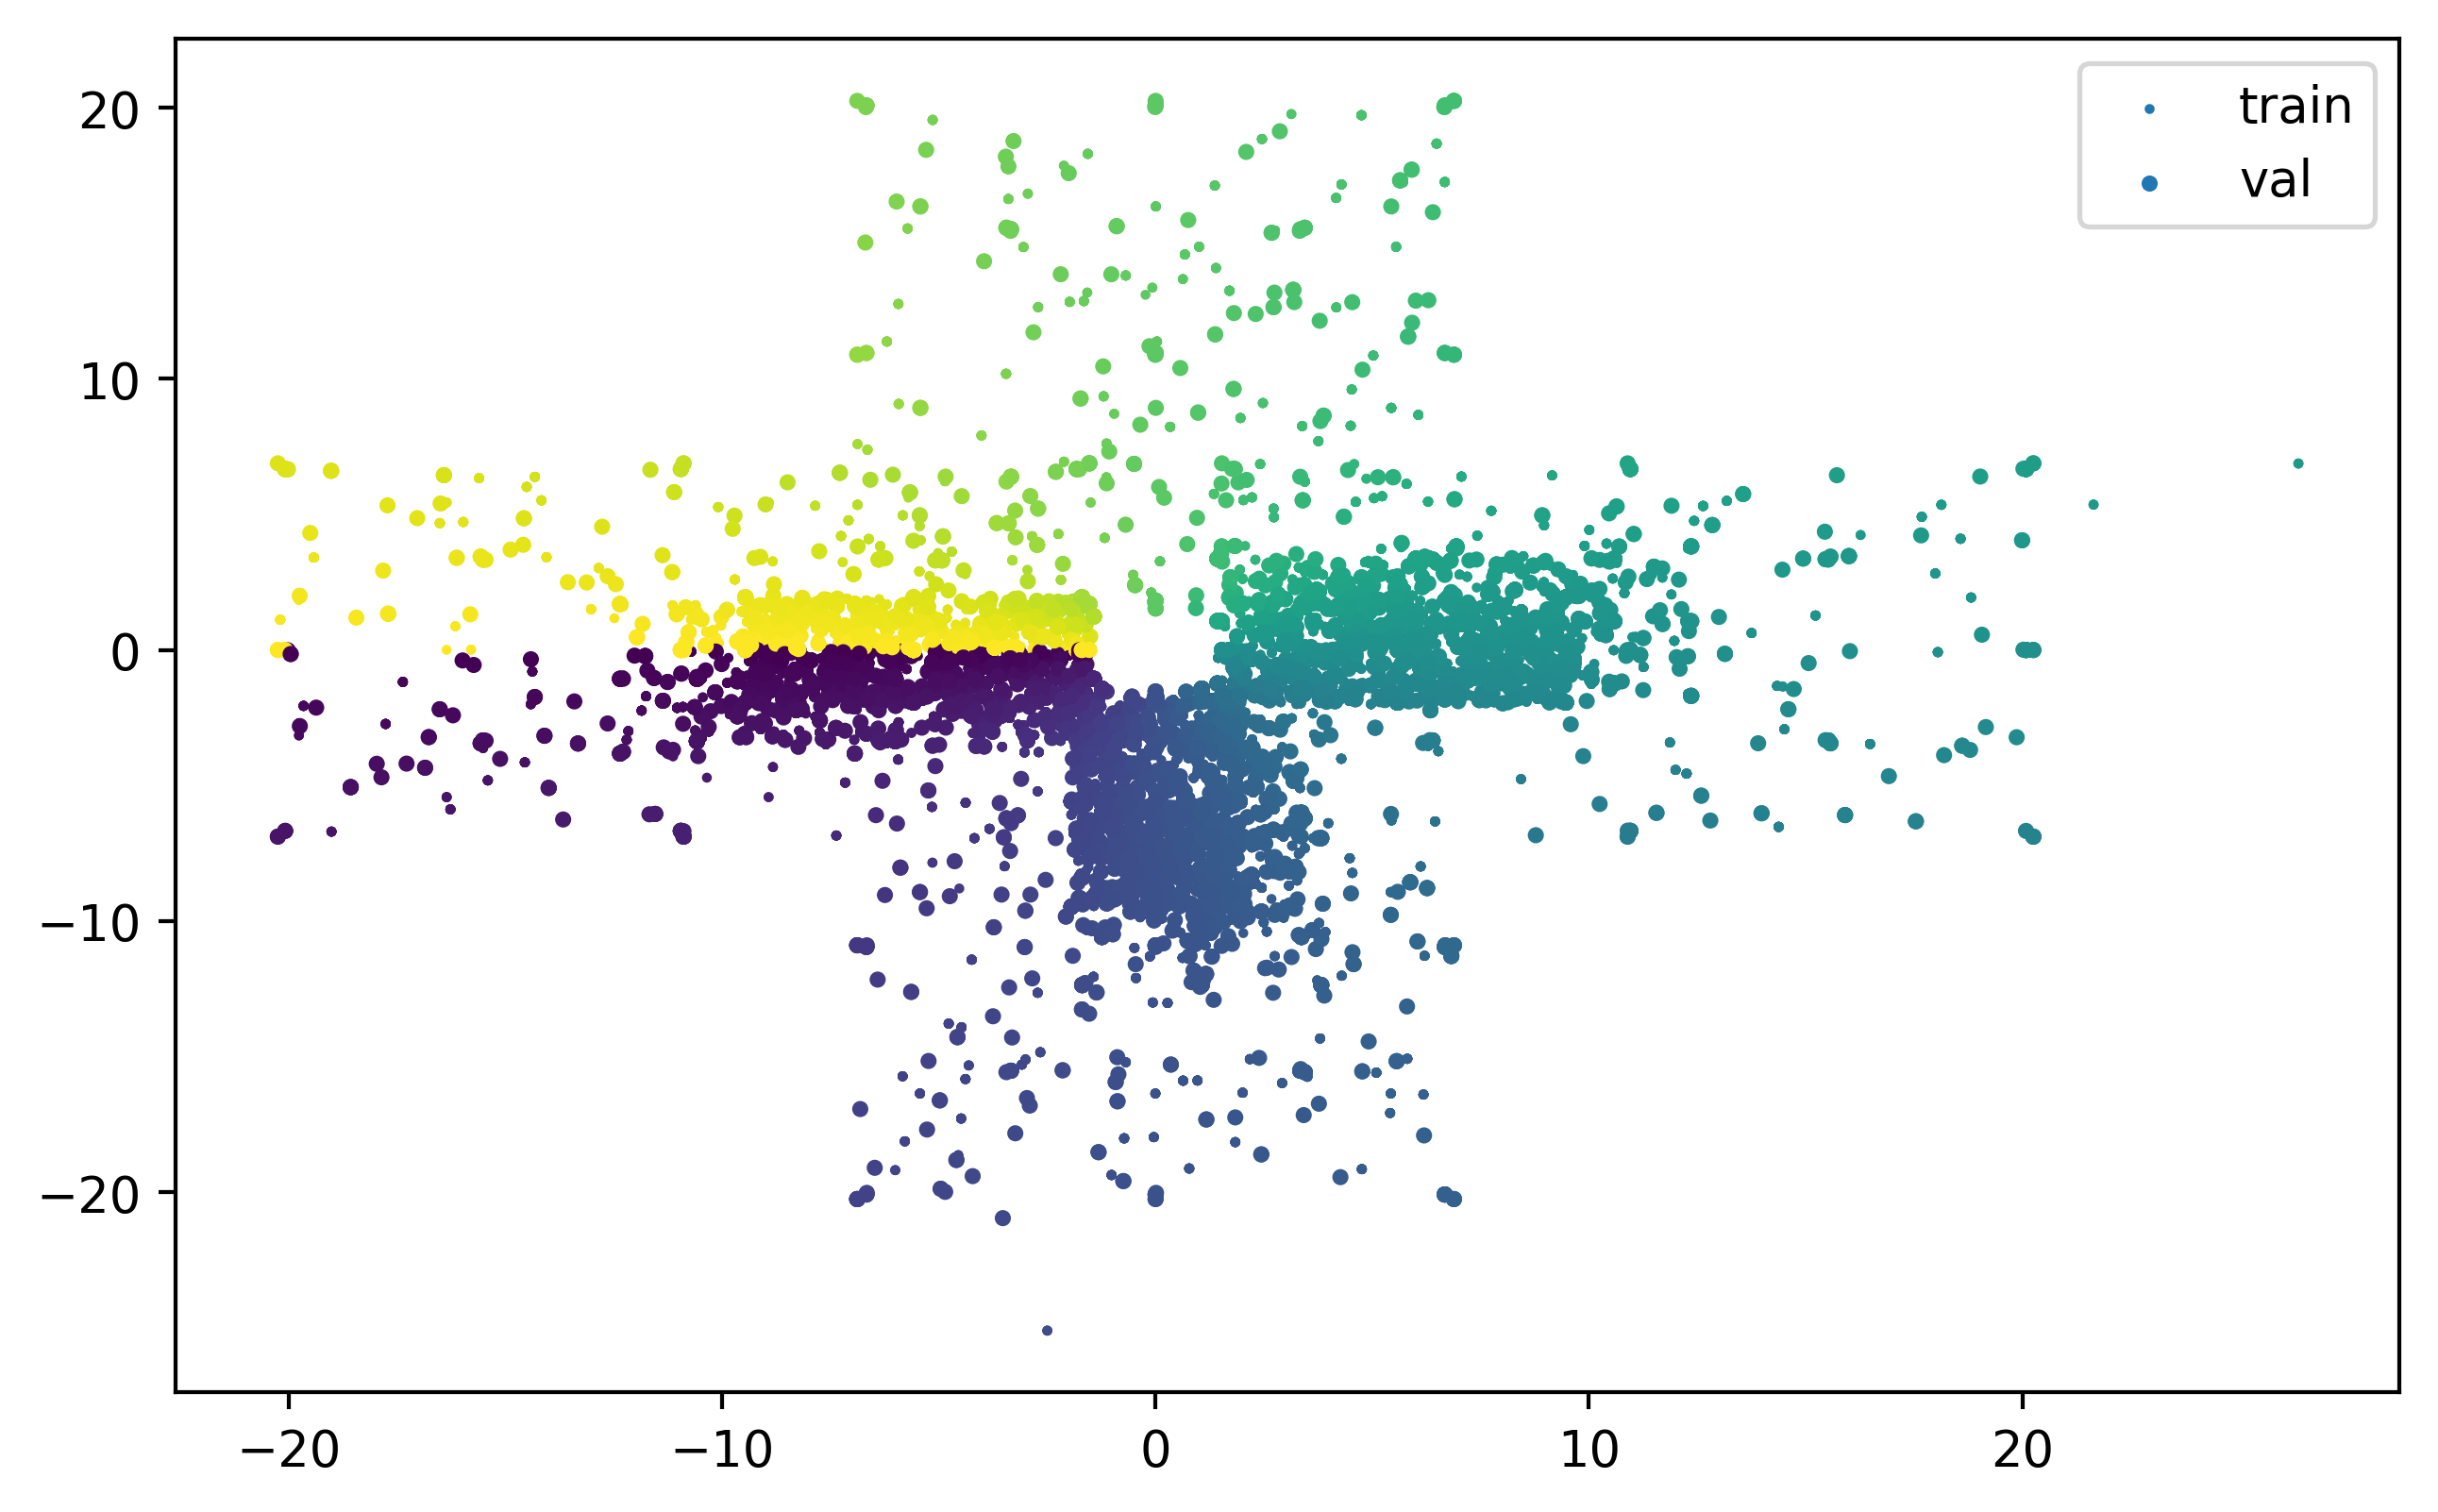

In [4]:
plt.figure(figsize=(8,5), dpi=380)
plt.scatter(data['train_y'][:,0],data['train_y'][:,1],1,label='train',c=np.arctan2(data['train_y'][:,1],data['train_y'][:,0]))
plt.scatter(data['val_y'][:,0],data['val_y'][:,1],5,label='val',c=np.arctan2(data['val_y'][:,1],data['val_y'][:,0]))
plt.legend()
plt.plot()
plt.show()